In [1]:
%pylab inline
from utils import wav2audio_segment, audiofigure, Descriptor, audiofigure, normalize
import pandas as pd
from sklearn import decomposition
import librosa
from  librosa.util import frame
import scipy
import IPython
%run ../utils.py

Populating the interactive namespace from numpy and matplotlib


In [2]:
path = "../wavs/"
fnames = ["Grisey_partiels.wav"]
T1 = 1
T2 = 40
# fnames = ["Stockhausen_Kontakte.wav"]
# T1 = 40
# T2 = 52
# fnames = ["BeachBoys_SurfinUSA.wav"]
# T1 = 1
# T2 = 20

In [3]:
n_mfcc = 20
NFFT = 2**12
HOP = int(NFFT/4)
WIN_LENGTH = NFFT
sr = 44100


In [4]:
DESCRIPTORS = [

{'name': 'mfcc',
 'params': {'n_mfcc':n_mfcc,'sr':sr},
 'function': lambda self,y: librosa.feature.mfcc(S=Sm, **self.params).T },

{'name': 'rmse',
 'params': {},
 'function': lambda self,y: librosa.feature.rmse(S=Sm).T },

{'name': 'rolloff',
 'params': {'sr':sr},
 'function': lambda self,y: librosa.feature.spectral_rolloff(S=Sm,sr=sr).T },
    
{'name': 'centroid',
 'params': {'sr':sr},
 'function': lambda self,y: librosa.feature.spectral_centroid(S=Sm,**self.params).T },
    
{'name': 'scontrast',
 'params': {'sr':sr} ,
 'function' : lambda self,y: librosa.feature.spectral_contrast(S=Sm, **self.params).T },

# {'name': 'chroma',
#  'params':{} ,
#  'function': lambda self, y: librosa.feature.chroma_stft(S=Sm, **self.params).T }
]

In [5]:
audio = {}
df = pd.DataFrame()

for fname in fnames:
    sr, signal  = wav2audio_segment(path+fname,T1,T2)

    S = librosa.stft(signal,n_fft=NFFT, hop_length=HOP,center=False)
    Sm = abs(S)
    
    ntotal = signal.size
    durtotal = ntotal/sr
    
    normdata = []
    data = []
    multiindex = []
    
    for D in DESCRIPTORS:
        d = Descriptor(D)
        d.perform(signal)
        data.append(d.data)
        ndata = normalize(d.data)
        normdata.append(ndata)
        
            
        multiindex += [ (d.name,i) for i in range(d.data.shape[1]) ]
    

/usr/local/lib/python2.7/dist-packages/scipy/io/wavfile.py:221: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [6]:
frames = frame(signal, frame_length=NFFT, hop_length=HOP)
normframes = frames/sqrt((frames**2).mean(0))

In [7]:
columns = pd.MultiIndex.from_tuples(multiindex, names=['Descriptor', 'Feature'])
df = pd.DataFrame(np.hstack(data),columns = columns)
normdf = pd.DataFrame(np.hstack(normdata),columns = columns)

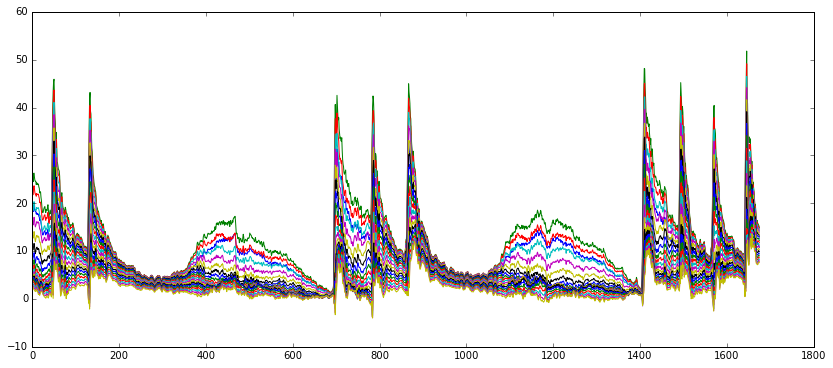

In [8]:
figure(figsize=(14,6))
plot(df.mfcc);

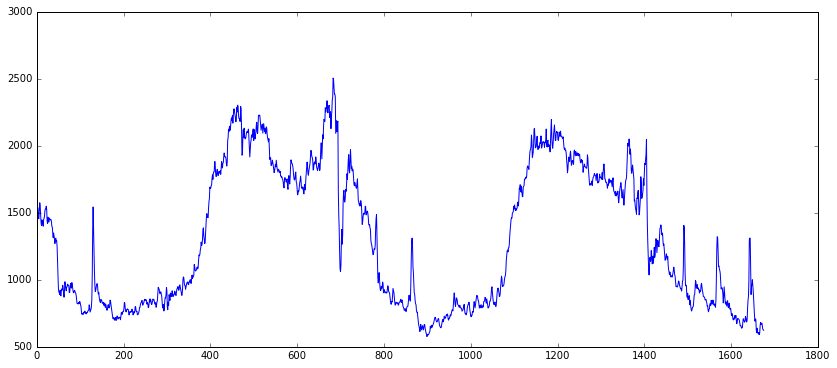

In [9]:
figure(figsize=(14,6))
plot(df.centroid);

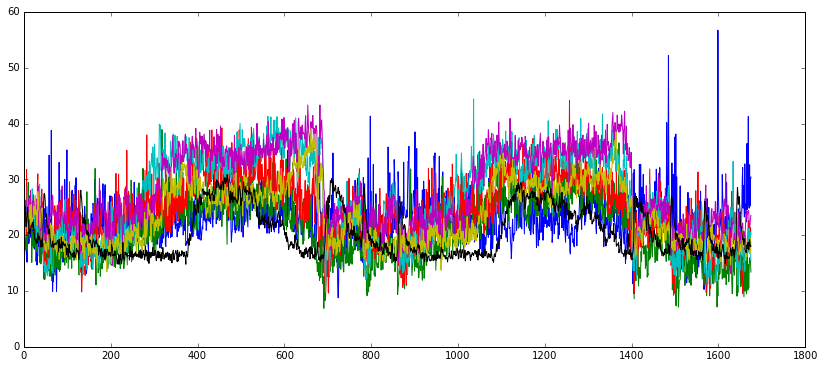

In [10]:
figure(figsize=(14,6))
plot(df.scontrast);

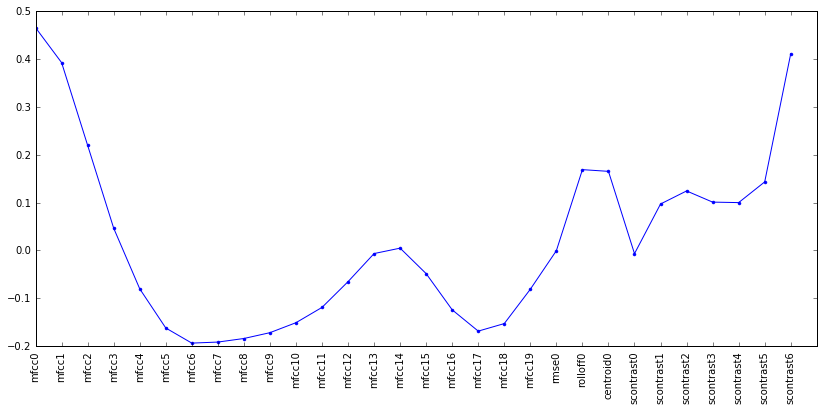

In [11]:
figure(figsize=(14,6))

pca = decomposition.PCA(n_components=20)
Ypca = pca.fit_transform(normdf.values)
plot(pca.components_[0,:],'.-')
xlab = [df.columns.levels[0][a]+str(df.columns.levels[1][b]) for (a,b) in zip(list(df.columns.labels[0]),list(df.columns.labels[1]))]
plt.xticks(range(normdf.shape[1]), xlab, rotation='vertical');

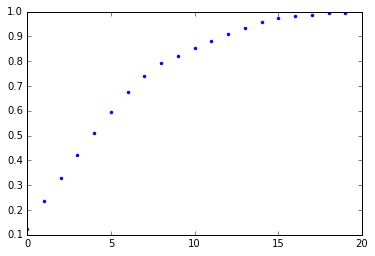

In [12]:
plot(cumsum(pca.explained_variance_ratio_),'.')
maxpca= where(cumsum(pca.explained_variance_ratio_)>0.9)[0][0]

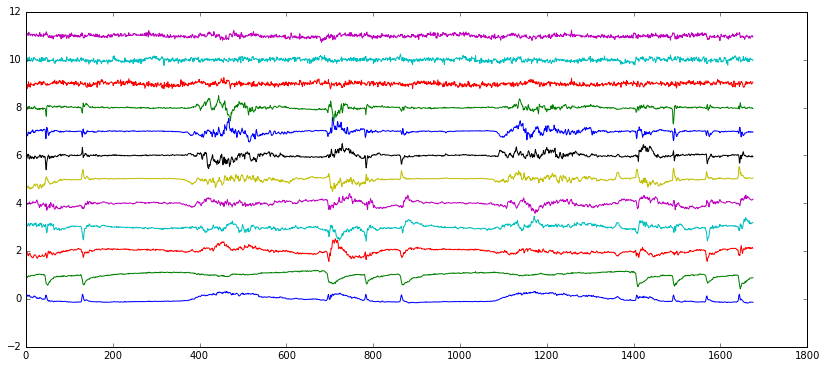

In [13]:
figure(figsize=(14,6))
Ypca = Ypca[:,:maxpca]
plot(Ypca+arange(maxpca));

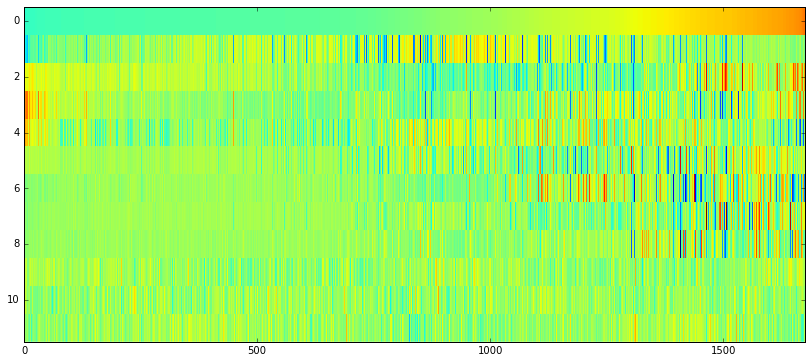

In [14]:
# Y = df.rmse.values

idx = lexsort(np.flipud(Ypca.T))
# idx = list(range(Y.shape[0]))
figure(figsize=(14,6))
imshow(Ypca.T[:,idx],aspect='auto',interpolation='none');

In [15]:
framesorder = frames[:,idx]

In [17]:
outsignal = framesoverlap(framesorder,HOP, WIN_LENGTH )
IPython.display.Audio(data=outsignal,rate=sr)
librosa.output.write_wav('../talk/grisey_sorted.wav',outsignal,sr=sr)

In [104]:
from sklearn.neighbors import NearestNeighbors
Y = df.values
nbrs = NearestNeighbors(n_neighbors=20, algorithm='brute',metric='euclidean').fit(Y) #kd_tree

In [105]:
distances, indices = nbrs.kneighbors(Y)

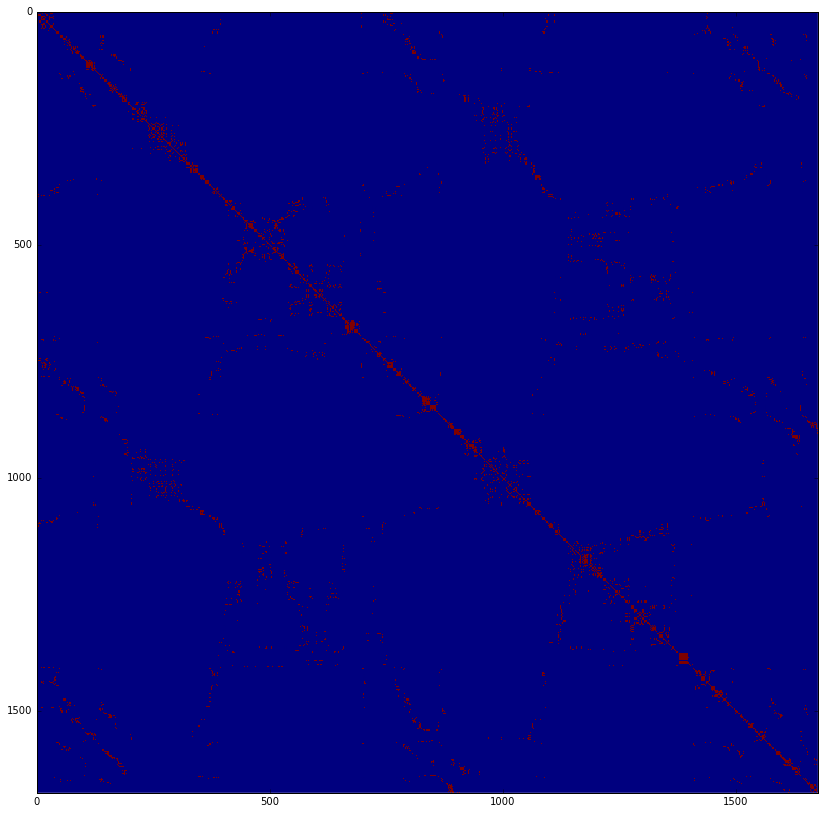

In [106]:
figure(figsize=(14,14))
B = nbrs.kneighbors_graph(Y)
# B = B - scipy.sparse.diags(ones(B.shape[0]))
imshow(B.toarray(),interpolation='none');

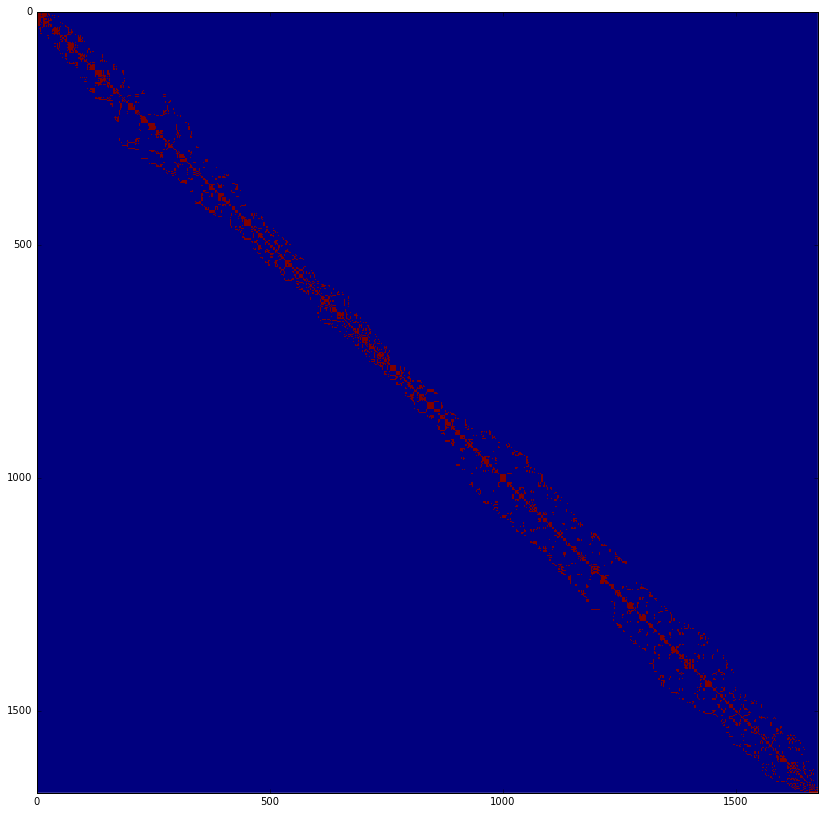

In [107]:
figure(figsize=(14,14))
perm = scipy.sparse.csgraph.reverse_cuthill_mckee( B )
BB = B.toarray()
imshow(BB[perm,:][:,perm],interpolation='none');

In [108]:
outsignal = framesoverlap(frames[:,perm],HOP, WIN_LENGTH )
IPython.display.Audio(data=outsignal,rate=sr)